# Create artifact from time series dataframe

In [17]:
import pandas as pd
import numpy as np
from fastcore.all import *
import wandb
from tchub.load import TSArtifact, infer_or_inject_freq
import pickle
import matplotlib.pyplot as plt

### Notebook config

In [18]:
base_path = Path.home()

In [19]:
config = AttrDict(
    use_wandb = False, # Whether to use or not wandb for experiment tracking
    wandb_entity = 'pacmel',
    wandb_project = 'tchub',
    #base_path = Path.home()/'data/stumpy/', # Folder path where you data lives
    data_fpath = base_path/'data/stumpy/steamgen.csv', # Name of the data file. Must be a pickle file
    variables_file_name = None,
    time_col = None, # Put here the idx of the column containing the timestamp, if any (e.g. 0 for taxi)
    data_cols = [3], # Put here the idxs of the columns of interest ([] for all)
    wandb_artifacts_path = 'data/wandb_artifacts', # Output path where the resulting TSArtifact will be stored
    artifact_name = 'steamflow', # Name of the artifact to be created
    joining_validation_test = False, #True to create an artifact linking validation and testing data or False if it doesn't
    # training, validation and testing days
    range_training = None, # in days. Set to None for full dataset
    range_validation = None, # in days. Set to None for validation=training
    range_testing = None,  # in days. Set to None for no training
    resampling_freq = '3s', # resampling frequency. It can be used to force a sampling freq to data without an index
    normalize_training = False,
    missing_values_technique='linear_interpolation' # handle missing values technique
)

### Run

For the experiment tracking and hyperparameter we will use the tool **Weights & Biases**. 

Before running this notebook part, make sure you have the `$WANDB_API_KEY` environment varibale defined with your API_KEY (run in a terminal `echo $WANDB_API_KEY` to see it). If not, run in a terminal `wandb login [API_KEY]`. You can see your API_KEY [here](https://wandb.ai/authorize) or in the settings of your W&B account.

In [20]:
# IMPORTANT! --> use wandb.init(..., mode='disabled', ...) to test W&B API without uploading anything to the clouds
run = wandb.init(entity = config.wandb_entity, 
                 project=config.wandb_project, 
                 job_type='create_dataset', 
                 resume=True,
                 mode='online' if config.use_wandb else 'disabled',
                 config=config)
config = run.config

#### Data Extraction

The data is assumed to come as a dataframe, either as a binarized  picke file or
as a csv file

In [21]:
ext = str(config.data_fpath).split('.')[-1]
if ext == 'pickle':
    f = open(config.data_fpath, 'rb')
    bin_data = f.read()
    data_file = pickle.loads(bin_data)
    df = data_file[0]
elif ext == 'csv':
    df = pd.read_csv(config.data_fpath)
else:
    raise Exception('The data file path has an unsupported extension')
print(f'File loaded successfully')
print(df.shape)
df.head()

File loaded successfully
(9600, 4)


,drum pressure,excess oxygen,water level,steam flow
0,320.08239,2.506774,0.032701,9.302970
1,321.71099,2.545908,0.284799,9.662621
2,320.91331,2.360562,0.203652,10.990955
3,325.00252,0.027054,0.326187,12.430107
4,326.65276,0.285649,0.753776,13.681666


Set the time columm (if any) as an index

In [22]:
if config.time_col is not None: df = df.set_index(pd.DatetimeIndex(df.iloc[:, config.time_col]), drop=False)
df.head()

,drum pressure,excess oxygen,water level,steam flow
0,320.08239,2.506774,0.032701,9.302970
1,321.71099,2.545908,0.284799,9.662621
2,320.91331,2.360562,0.203652,10.990955
3,325.00252,0.027054,0.326187,12.430107
4,326.65276,0.285649,0.753776,13.681666


In [23]:
df = infer_or_inject_freq(df, injected_freq=config.resampling_freq)
df.index.freq

<3 * Seconds>

Subset number of variables

In [24]:
if config.data_cols != []: df = df.iloc[:, config.data_cols]
print(f'Num. variables: {len(df.columns)}')

Num. variables: 1


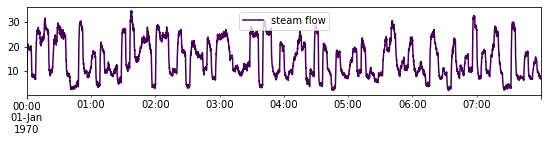

In [25]:
#slow
df.plot(subplots=True, figsize=(15,15), layout=(8,2),  sharex=True, colormap='viridis')
plt.tight_layout()

#### Data Transformation

##### 1. Previous transformations
In this part, filters or transformation can be defined depending on variables origin or time-dependent features, among others.

In [26]:
# TODO: deprecate this??
# variables types
if config.variables_file_name:
    var_df = pd.read_csv(f'{config.base_path}/{config.variables_file_name}', index_col='Variable name')
    data_var_type = {var : var_df.loc[var,'Type'] for var in main_df.columns}
    data_var_type
    # only double variables type are stored
    double_var_list = [var for var, var_type in data_var_type.items() if var_type=='double']
    df = df[df.columns.intersection(double_var_list)]
else:
    df = df
print(f'Num. variables: {len(df.columns)}')

Num. variables: 1


##### 2. Handle Missing Values, Resample and Normalize
In this second part, Time Series Artifact (TSArtifact) object can be created and missing values handling techniques, resampling and normalization can be applied. This techniques should be applied on the three subsets that must be previously created: training, validation and testing.

In [27]:
# Training data
rg = config.range_training
df_training = df.query('index.dt.day.isin(@rg)') if rg is not None else df
training_artifact = TSArtifact.from_df(df_training, 
                                       name=config.artifact_name, 
                                       missing_values_technique=config.missing_values_technique,
                                       resampling_freq=config.resampling_freq, 
                                       normalize=config.normalize_training, 
                                       path=str(Path.home()/config.wandb_artifacts_path))
training_artifact.metadata

{'TS': {'sd': '1970-01-01 00:00:00',
  'ed': '1970-01-01 07:59:57',
  'created': 'from-df',
  'n_vars': 1,
  'handle_missing_values_technique': 'linear_interpolation',
  'has_missing_values': 'False',
  'n_samples': 9600,
  'freq': '<3 * Seconds>',
  'vars': ['steam flow'],
  'hash': '1168546725031912409'}}

In [28]:
# Validation data
rg = config.range_validation
df_validation = df.query('index.dt.day.isin(@rg)') if rg is not None else df_training
validation_artifact = TSArtifact.from_df(df_validation,
                                         name=config.artifact_name, 
                                         missing_values_technique=config.missing_values_technique,
                                         resampling_freq=config.resampling_freq, 
                                         normalize=False,
                                         path=str(Path.home()/config.wandb_artifacts_path))
validation_artifact.metadata

{'TS': {'sd': '1970-01-01 00:00:00',
  'ed': '1970-01-01 07:59:57',
  'created': 'from-df',
  'n_vars': 1,
  'handle_missing_values_technique': 'linear_interpolation',
  'has_missing_values': 'False',
  'n_samples': 9600,
  'freq': '<3 * Seconds>',
  'vars': ['steam flow'],
  'hash': '1168546725031912409'}}

In [29]:
# Testing data
rg = config.range_testing
if rg is not None:
    df_testing = df.query('index.dt.day.isin(@rg)')
    testing_artifact = TSArtifact.from_df(df_testing,
                                      name=config.artifact_name, 
                                      missing_values_technique=config.missing_values_technique,
                                      resampling_freq=config.resampling_freq, 
                                      normalize=False,
                                      path=str(Path.home()/config.wandb_artifacts_path))
    testing_artifact.metadata
else: testing_artifact = None

In [30]:
# Validation + Testing data
if(config.joining_validation_test):
    val_test_range = list(config.range_validation) + list(config.range_testing)
    df_val_test = df.query('index.dt.day.isin(@val_test_range)')
    val_test_artifact = TSArtifact.from_df(df_val_test,
                                           name=config.artifact_name, 
                                           missing_values_technique=config.missing_values_technique,
                                           resampling_freq=config.resampling_freq, 
                                           normalize=False,
                                           path=str(Path.home()/config.wandb_artifacts_path))
    print(val_test_artifact.metadata)

#### Data Loading

In [31]:
# log the artifacts

run.log_artifact(training_artifact)
run.log_artifact(validation_artifact)
if testing_artifact: run.log_artifact(testing_artifact)

if(config.joining_validation_test):
    run.log_artifact(val_test_artifact)

In [32]:
run.finish()